In [38]:
import importlib
import src.rossmann.data_load as dl
import src.rossmann.data_prep as dp
import pandas as pd

# reload order matters: data_load first, then data_prep
importlib.reload(dl)
importlib.reload(dp)

sales_path = r'C:\Users\hsnal\OneDrive\Documents\Python\projects\RossmannStoreSales\src\data\raw\SalesData.csv'
store_path = r'C:\Users\hsnal\OneDrive\Documents\Python\projects\RossmannStoreSales\src\data\raw\StoreData.csv'

# OPTION B: force-fill dates for “no competitor” rows
df, df_ml = dp.load_rossmann_data(
    sales_path, store_path,
    force_fill_open_date_for_no_competitor=True,
    # optional: choose the fill date instead of earliest sales date
    # no_competitor_fill_date="2013-01-01",
)

print(df_ml[['CompetitionDistance','CompetitionDistance_log1p','competition_open_date','promo2_start_date']].isna().sum())
print("NaT% competition_open_date:", df_ml['competition_open_date'].isna().mean())


c:\Users\hsnal\OneDrive\Documents\Python\projects\RossmannStoreSales\src\rossmann\data_prep.py:159: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  open_days_ltm     = grp.apply(lambda g: (g['Open'] == 1).sum()).rename('open_days_ltm')
c:\Users\hsnal\OneDrive\Documents\Python\projects\RossmannStoreSales\src\rossmann\data_prep.py:170: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  promo_mean = grp.apply(lambda g: _avg_by

CompetitionDistance               0
CompetitionDistance_log1p         0
competition_open_date             0
promo2_start_date            508031
dtype: int64
NaT% competition_open_date: 0.0


C:\Users\hsnal\AppData\Local\Temp\ipykernel_29332\2719451472.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


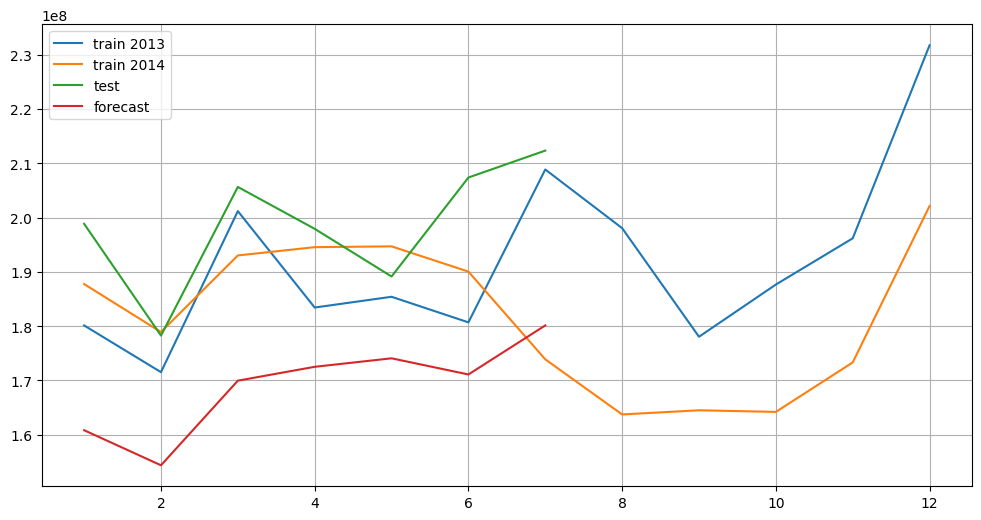

In [ ]:
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

df_ml_monthly=df_ml.copy().groupby(['Date'])[['Sales']].sum().reset_index()
df_ml_monthly.set_index('Date',inplace=True)
df_ml_monthly=df_ml_monthly.resample('MS').sum()
df_ml_monthly['Year'] = pd.DatetimeIndex(df_ml_monthly.index).year
df_ml_monthly['Month'] = pd.DatetimeIndex(df_ml_monthly.index).month

min_date=df_ml_monthly.index.min()
max_date=df_ml_monthly.index.max()
available_period=np.ceil((max_date-min_date).days/30)
periods_needed=24
max_Ntest=available_period-periods_needed

Ntest=7
ytrain=df_ml_monthly[:-Ntest]
ytest=df_ml_monthly[-Ntest:]
max_year_range=df_ml_monthly.index.year.max()
min_year_range=df_ml_monthly.index.year.min()


trend='add'
seasonal='add'
seasonal_period=12
damped_trend=False
initialization_method='estimated'
optimized='optimized'
model=ExponentialSmoothing(
    ytrain['Sales'],
    trend=trend,
    seasonal=seasonal,
    seasonal_periods=seasonal_period,
    damped_trend=damped_trend,
    initialization_method=initialization_method,
).fit(optimized=optimized)

forecast=model.forecast(Ntest)



plt, ax =plt.subplots(figsize=(12, 6))
last_train_date=ytrain.iloc[-1]
#ytest=pd.concat([last_train_date,ytest])
#forecast=pd.concat([forecast,last_train_date])
for year in sorted(ytrain.index.year.unique()):
    df_pre=ytrain[ytrain.index.year==year]
    ax.plot(df_pre['Month'],df_pre['Sales'], label=f"train {year}")
ax.plot(ytest['Month'],ytest['Sales'], label="test")
ax.plot(ytest['Month'],forecast, label="forecast")
ax.legend()
ax.grid()
plt.show()


In [45]:
ytest

,Sales,Year,Month
Date,,,
2015-01-01,198843730,2015,1
2015-02-01,178275458,2015,2
2015-03-01,205631683,2015,3
2015-04-01,197918886,2015,4
2015-05-01,189143897,2015,5
2015-06-01,207363373,2015,6
2015-07-01,212322616,2015,7


C:\Users\hsnal\AppData\Local\Temp\ipykernel_29332\3648698385.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


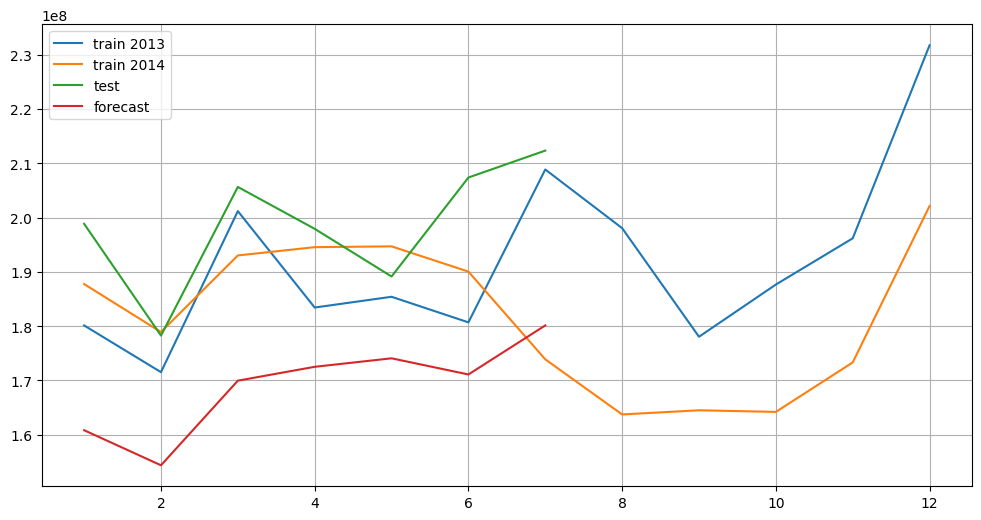